In [1]:
import tensorflow as tf 
import keras

from sklearn.feature_extraction.text import TfidfVectorizer
import glob
import os 
import pandas as pd
import datetime
from scipy.stats import iqr
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer as SimpleImputer
# from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
%matplotlib inline

import math

spm = None
english_words = None
excepted_stock_names = []
limit = -1

Using TensorFlow backend.


In [2]:
import keras
from keras.layers import Dense, Dropout, RepeatVector, BatchNormalization, Convolution1D, Flatten, Lambda, Permute, MaxPooling1D, AlphaDropout
from keras.models import Sequential
from keras.utils import to_categorical
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tqdm import *

In [3]:
class DateRange():
    def __init__(self, start_int, end_int):
        self.start_int = start_int
        self.end_int = end_int
        self.range = (range(start_int, end_int))

    def transform(self, date):
        output = {}
        dates = []
        for delta in self.range:
            date_delta = datetime.timedelta(days=delta)
            date_string = datetime.datetime.strptime(date, '%Y-%m-%d').date()
            dates.append(str(date_string + date_delta))
        return dates

In [4]:
class PriceData:
    def __init__(self, stock_name):
        self.stock_name = stock_name
        try:
            self.price_data = pd.read_csv('prices/' + stock_name + '.csv')
        except:
            self.price_data = pd.DataFrame.from_dict({})

    def on_date(self, date, market_time = 'open'): 
        try:
            return float(self.price_data.loc[self.price_data['date'] == date][market_time])
        except: 
            return None

In [5]:
class X_y_mapping():
    def __init__(self, start_int, end_int):
        self.filing_int = start_int * -1
        self.start_int = start_int
        self.end_int = end_int
        self.range = (range(start_int, end_int))
        
    def __stock_name_from_filename(self, filename):
        return filename.split('/')[-1]
        
    def transform(self):
        stock_names = [self.__stock_name_from_filename(filename) for filename in glob.glob('proc_filing_texts/*')]
        price_ranges = self.__get_price_ranges(stock_names)
        X_y = {}
        for stock_name in price_ranges.keys():
            cp_ratio = self.__comparison_price_ratio(price_ranges, stock_name)
            if cp_ratio and not math.isnan(cp_ratio):
                X_y[stock_name] = cp_ratio
        return X_y
    
    
    def __get_price_ranges(self, stock_names):
        h = {}
        for i, stock_name in enumerate(stock_names):
            try:
                date = stock_name.split('_')[1]
            except:
                continue # Ignore stocks which don't have a date
            dates = []
            for delta in self.range:
                date_delta = datetime.timedelta(days=delta)
                date_string = datetime.datetime.strptime(date, '%Y-%m-%d').date()
                dates.append(str(date_string + date_delta))
            h[stock_name] = dates
        return h
    
    def __comparison_price_ratio(self,h, stock_name_with_date):
        earliest_price_after_filing = None
        hist_p = []
        stock_name = stock_name_with_date.split('_')[0]
        for i, date in enumerate(h[stock_name_with_date]):
            price = PriceData(stock_name).on_date(date, 'open')
            if price and not math.isnan(price):
                if i > self.filing_int:
                    earliest_price_after_filing = earliest_price_after_filing or price
                else:
                    hist_p.append(price)
        # Closing price on day of filing
        price_close_filing = PriceData(stock_name).on_date(h[stock_name_with_date][self.filing_int], 'close')
        # Use either the next open day of trading or the close price on day of filing
        comparison_price = earliest_price_after_filing or price_close_filing
        # Remove nans from historical prices before taking the mean
        this_mean = np.mean(hist_p)
        if comparison_price and this_mean:
            return ((comparison_price-this_mean)/this_mean)
        else:
            return None

In [6]:
spm = X_y_mapping(-3,4).transform()
len(spm)

/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3413

In [7]:
import operator
sorted(spm.items(), key=operator.itemgetter(1))

[('ABIO_2018-02-26', -0.548936170212766),
 ('BIOAQ_2018-02-05', -0.5120156939676312),
 ('ITRK_2018-03-15', -0.5),
 ('DERM_2018-03-05', -0.47513481126423013),
 ('NSPR_2018-03-29', -0.47474747474747475),
 ('AVGR_2018-02-15', -0.46273830155979195),
 ('BIOAQ_2018-02-08', -0.4268167860798361),
 ('TKCI_2018-06-04', -0.42105263157894735),
 ('VRCP_2018-03-21', -0.40981818181818186),
 ('CFMS_2018-01-24', -0.4024390243902439),
 ('MJTK_2018-02-28', -0.4000000000000001),
 ('PULM_2018-03-29', -0.3989313022171051),
 ('STCC_2018-02-02', -0.39574468085106385),
 ('USEL_2018-06-01', -0.3854748603351956),
 ('CSAX_2018-01-26', -0.38137952366223316),
 ('SPDL_2018-02-01', -0.37508125677139764),
 ('EXPL_2018-01-24', -0.37500000000000006),
 ('PI_2018-02-01', -0.3607305936073059),
 ('LTBR_2018-01-25', -0.33478260869565213),
 ('DARE_2018-02-13', -0.3294117647058823),
 ('RNVA_2018-03-06', -0.32596685082872917),
 ('GIDYL_2018-03-01', -0.32258064516129026),
 ('DARE_2018-02-12', -0.32203389830508466),
 ('EGC_2018-0

In [9]:
class FilenamesToStockNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        output = []
        for filename in X:
            stock_name = self.__stock_name_from_filename(filename)
            output.append(stock_name)
        return output
    def __stock_name_from_filename(self, filename):
        return filename.split('/')[-1].split('_')[0]

In [10]:
## Used in y pipeline
class SpmToFileNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    def transform(self, X):
        output = []
        for key in X.keys():
            output.append(f'proc_filing_texts/{key}')
        return output
    
class SpmToStockNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return X.keys()
    
class StockNamesToFileNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return [f'filing_texts/{stock_name}' for stock_name in X]
    
class StatisticalMeasuresTransformer(BaseEstimator, TransformerMixin):
    # Returns the interquartile-range and median.
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        # ldcom = last_day_change_over_median
        
        output = []
        self.iqr_var = []
        self.median = []
        for prices in X:
            this_iqr = iqr(prices[0:-3])
            this_median = np.median(prices[0:-3])
            self.iqr_var.append(this_iqr)
            self.median.append(this_median)
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        X_output = []
        for i, prices in enumerate(X):
            stats   = []
            iqr_var = self.iqr_var[i] or iqr(prices)
            median  = self.median[i]  or np.median(prices)
            
            stats.append(iqr_var)
            stats.append(median)
            
            X_output.append(stats)
        return np.array(X_output)
class SparseToArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return np.array(X.toarray()) #[ar.toarray() for ar in X]
    
class ReadFiles(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return (open(filename, 'r').read() for filename in tqdm(X))
            

In [11]:
class SpmToContinuousLabelsTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return np.array(list(X.values()))

In [12]:
# Used to build other pipelines
from sklearn.preprocessing import Imputer

labels_pipeline = Pipeline([
    ('dates_to_prices_transformer', SpmToContinuousLabelsTransformer())
])

text_word_counts = Pipeline([
    ('spm_to_file_names', SpmToFileNamesTransformer()),
    ('read_files', ReadFiles()),
    ('vect', TfidfVectorizer(
                token_pattern=r"[a-zA-Z]+", 
                min_df = 0.03,
                max_df = 0.75,
                stop_words = 'english',
                ngram_range=(1, 7))),
    ('sparse_to_array', SparseToArray()),
    ('std_scaler', StandardScaler(with_mean=False)),
])


In [13]:
X = text_word_counts.fit_transform(spm)
y = labels_pipeline.fit_transform(spm)
print(X.shape)
print(y.shape)

100%|██████████| 3413/3413 [04:38<00:00, 12.26it/s]


(3413, 21186)
(3413,)


In [ ]:
# pickle.dumps(X, 'X')

In [17]:
def get_weighted_return(prob_preds, threshold):
    total = 0
    amount_wagered = 0
    bet_amount = 1
    bets = 0
    good_is = []
    for i, confidence in enumerate(prob_preds):
        if confidence >= threshold:
            return_v = y_test_continuous[i]
            good_is.append(i)
#             print(f'{confidence} confidence, {return_v} return')
            total += (bet_amount * confidence * return_v)
            amount_wagered += bet_amount * confidence
            bets += 1

    if amount_wagered == 0:
        print('No confident bets')
    else:
        av_return = total/float(amount_wagered)
        print(f'{bets} bets, {total} return. {av_return} av return')
        print(good_is)

In [18]:
def get_unweighted_return(pred, threshold):
    total = 0
    amount_wagered = 0
    bet_amount = 1
    bets = 0
    good_is = []
    for i, confidence in enumerate(pred):
        if confidence >= threshold:
            return_v = y_test_continuous[i]
            good_is.append(i)
#             print(f'{confidence} confidence, {return_v} return')
            total += (bet_amount * return_v)
            amount_wagered += bet_amount
            bets += 1

    if amount_wagered == 0:
        print('No confident bets')
    else:
        av_return = total/float(amount_wagered)
        print(f'{bets} bets, {total} return. {av_return} av return')
        print(good_is)

In [19]:
X_train, X_test, y_train_continuous, y_test_continuous = train_test_split(X, y, test_size=0.2)
def bool_arr(arr, limit=0.5):
    y_bool = []
    for num in arr:
        if num >= limit:
            y_bool.append(1)
        else:
            y_bool.append(0)
    return np.array(y_bool)
y_train = bool_arr(y_train_continuous, 0.01)
y_test = bool_arr(y_test_continuous, 0.01)

## Support Vector Classifier

In [ ]:
from sklearn.feature_selection import SelectFpr
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import tensorflow as tf


# class_weights = []
# for i in np.linspace(0.01,0.1, num=10):
#     class_weights.append({0: i, 1: 1-i})

# param_grid = dict(
#     class_weight=class_weights
# )

# svc_train_pipeline = Pipeline([
#     ('reduce_false_pos', SelectFpr(alpha=0.9)),
#     ('svc', RandomizedSearchCV(estimator=SVC(
#         gamma='auto', 
#         kernel='sigmoid',
#         C=0.5623,
#         probability=True,
#         class_weight='balanced'), 
#         scoring='average_precision',
#         param_distributions=param_grid))
#      ])

from sklearn.svm import LinearSVC
svc_train_pipeline = Pipeline([
    ('reduce_false_pos', SelectFpr(alpha=0.9)),
    ('svc', LinearSVC(
        gamma='auto', 
        kernel='text',
        C=0.5623,
        probability=True,
        class_weight='balanced'))
     ])
svc_train_pipeline.fit(X_train, y_train)
print(svc_train_pipeline.score(X_test, y_test))
svc_prob_preds = svc_train_pipeline.predict_proba(X_test)[:, 1]
get_weighted_return(svc_prob_preds, 0.45)

In [ ]:
get_weighted_return(svc_prob_preds, 0.45)

### Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

l_svc = LinearSVC(
        kernel='text',
        probability=True,
        class_weight='balanced')

s_svc = SVC(
        gamma='auto', 
        kernel='sigmoid',
        C=0.5623,
        probability=True,
        class_weight='balanced')

rfc = RandomForestClassifier(
    min_weight_fraction_leaf=0.02,
    n_jobs=-1
)    

vc = VotingClassifier(
    [
        ('l_svc', l_svc),
        ('s_svc', s_svc),
        ('rfc', rfc)
    ],
    voting='soft'
)
vc.fit(X_train, y_train)
print(vc.score(X_test, y_test))
preds = vc.predict_proba(X_test)[:, 1]
get_weighted_return(preds, 0.45)

## Support Vector Regressor

In [422]:
from sklearn.feature_selection import SelectFpr
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import tensorflow as tf


param_distributions = dict(C=np.logspace(-1,1,num=10))

svr_train_pipeline = Pipeline([
    ('svc', RandomizedSearchCV(estimator=SVR(
        gamma='auto', 
        kernel='rbf'), 
        scoring='neg_mean_absolute_error',
        param_distributions=param_distributions))
     ])
svr_train_pipeline.fit(X_train, y_train_continuous)
print(svr_train_pipeline.score(X_test, y_test))



-0.4933139542581251


In [423]:
svc_prob_preds = svc_train_pipeline.predict(X_test)
get_weighted_return(svc_prob_preds, 0.03)
get_unweighted_return(svc_prob_preds, 0.03)

20 bets, 0.5321300286398862 return. 0.026606501431994313 av return
[2, 3, 10, 19, 28, 30, 37, 42, 43, 49, 53, 58, 62, 67, 70, 75, 76, 89, 96, 98]
20 bets, 0.5321300286398862 return. 0.026606501431994313 av return
[2, 3, 10, 19, 28, 30, 37, 42, 43, 49, 53, 58, 62, 67, 70, 75, 76, 89, 96, 98]


In [434]:
svr_prob_preds = svr_train_pipeline.predict(X_test)
get_weighted_return(svr_prob_preds, 0.021)
get_unweighted_return(svr_prob_preds, 0.021)

8 bets, 0.00398947972416052 return. 0.023264985931279722 av return
[12, 19, 31, 49, 70, 71, 89, 90]
8 bets, 0.18362775323697944 return. 0.02295346915462243 av return
[12, 19, 31, 49, 70, 71, 89, 90]


In [ ]:
a = svr_train_pipeline.predict(X_test)
a.sort()
plt.plot(a)

In [ ]:
a = svc_train_pipeline.predict_proba(X_test)
a.sort()
plt.plot(a)

In [ ]:
ya = y_train_continuous
ya.sort()
plt.plot(ya)

In [ ]:
% matplotlib inline
pred = svc_train_pipeline.predict_proba(X_test)[:, 1]
plt.hist(pred, bins=100, range=(0,1))
None

In [296]:
np.sum(y_test_continuous)/len(y_test_continuous)

0.013314499907574611

## What are the returns given by this model over a range of confidence level cutoffs?

(-0.02, 0.02)

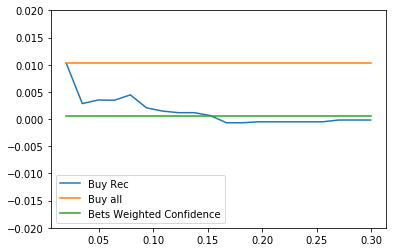

In [218]:
def score(est, X, y, cutoff):
    y_pred = est.predict_proba(X)[:,1]
    # Invest if over cutoff% confident 
    y_pred_bool = bool_arr(y_pred, cutoff)
    
    total = np.dot(y_pred_bool, y)
    confidence_weighted = np.dot(y_pred, y)
    buy_all = np.dot(np.ones(X.shape[0]), y)
    
    av = total/len(X)
    buy_all_av = buy_all/len(X)
    confidence_weighted_av = confidence_weighted/len(X)
    return [av, buy_all_av, confidence_weighted_av]


ys_attained = []
ys_potential = []
ys_confidence_weighted = []
xs = []

preds = svc_train_pipeline.predict_proba(X_test)[:, 1]

for i in np.linspace(preds.min(), preds.max(), num=20):
    sc = score(svc_train_pipeline, X_test, y_test_continuous,i)
    ys_attained.append(sc[0])
    ys_potential.append(sc[1])
    ys_confidence_weighted.append(sc[2])
    xs.append(i)
    
buy_rec = plt.plot(xs, ys_attained, label='Buy Rec')
buy_all = plt.plot(xs, ys_potential, label='Buy all')
buy_wc = plt.plot(xs, ys_confidence_weighted, label='Bets Weighted Confidence')

ax = plt.gca()

handles, labels = ax.get_legend_handles_labels()
ax.legend()

plt.ylim(-0.02, 0.02)

# set the ylim to ymin, ymax

In [28]:
from keras import regularizers
from sklearn.metrics import confusion_matrix

In [37]:
class DeepEstimator():
    def __init__(self):
        return None
    def fit(self, X, y, X_val, y_val):
        class_weight = {0: 0.4,
                1: 0.6}
        self.model = self.__define_model(X)
        sched = [[0.0001, 2], [0.001, 20], [0.01, 2], [0.1, 2], [0.5, 1], [0.1, 5], [0.01, 20], [0.001, 40], [0.0001, 80], [0.00005, 120]]
#         sched = [[0.0001, 10]]
        for lr, epochs in sched:
            self.model.optimizer.lr = lr
            self.model.fit(np.array(X), np.array(y), epochs=epochs, verbose=True, class_weight=class_weight, batch_size=2, validation_data=(X_val, y_val))
        return self
    def predict(self, X, y=None):
        return self.model.predict(X)
    def __define_model(self, X):
        shape = X.shape[1]
        model = Sequential([
            BatchNormalization(input_shape=(shape,)),
            Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.5)),
            Dropout(0.5),
            BatchNormalization(),
            Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.5)),
            Dropout(0.5),
            BatchNormalization(),
            Dense(1, activation='sigmoid')   
        ])

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model
    
X_train, X_test, y_train_continuous, y_test_continuous = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = bool_arr(y_train_continuous, 0.01)
y_test = bool_arr(y_test_continuous, 0.01)

select_fpr = SelectFpr(alpha=0.99)

X_train = select_fpr.fit_transform(X_train, y_train)
X_test = select_fpr.transform(X_test)

deep_estimator = DeepEstimator()
deep_estimator.fit(X_train, y_train, X_test, y_test)

Train on 395 samples, validate on 99 samples
Epoch 1/2
395/395 [==============================] - 2s 4ms/step - loss: 916.9180 - acc: 0.4835 - val_loss: 104.3271 - val_acc: 0.4848
Epoch 2/2
395/395 [==============================] - 1s 2ms/step - loss: 79.9711 - acc: 0.5114 - val_loss: 73.5444 - val_acc: 0.4444
Train on 395 samples, validate on 99 samples
Epoch 1/20
395/395 [==============================] - 1s 2ms/step - loss: 68.4274 - acc: 0.4987 - val_loss: 67.0310 - val_acc: 0.4747
Epoch 2/20
395/395 [==============================] - 1s 3ms/step - loss: 57.7453 - acc: 0.5013 - val_loss: 51.4705 - val_acc: 0.5657
Epoch 3/20
395/395 [==============================] - 1s 3ms/step - loss: 49.8719 - acc: 0.4911 - val_loss: 46.5924 - val_acc: 0.4141
Epoch 4/20
395/395 [==============================] - 1s 3ms/step - loss: 43.7061 - acc: 0.4835 - val_loss: 40.3626 - val_acc: 0.4545
Epoch 5/20
395/395 [==============================] - 1s 2ms/step - loss: 38.1530 - acc: 0.4506 - val_loss

395/395 [==============================] - 1s 4ms/step - loss: 3.2024 - acc: 0.4456 - val_loss: 3.5716 - val_acc: 0.4343
Epoch 9/40
395/395 [==============================] - 1s 4ms/step - loss: 3.2027 - acc: 0.4456 - val_loss: 3.5758 - val_acc: 0.4343
Epoch 10/40
395/395 [==============================] - 1s 4ms/step - loss: 3.2020 - acc: 0.4456 - val_loss: 3.5821 - val_acc: 0.4343
Epoch 11/40
395/395 [==============================] - 1s 4ms/step - loss: 3.2013 - acc: 0.4456 - val_loss: 3.5604 - val_acc: 0.4343
Epoch 12/40
395/395 [==============================] - 1s 4ms/step - loss: 3.2003 - acc: 0.4456 - val_loss: 3.5853 - val_acc: 0.4343
Epoch 13/40
395/395 [==============================] - 1s 4ms/step - loss: 3.2002 - acc: 0.4456 - val_loss: 3.5720 - val_acc: 0.4343
Epoch 14/40
395/395 [==============================] - 1s 4ms/step - loss: 3.2004 - acc: 0.4456 - val_loss: 3.5709 - val_acc: 0.4343
Epoch 15/40
395/395 [==============================] - 1s 4ms/step - loss: 3.2002 

KeyboardInterrupt: 

In [30]:
# deep_estimator.model.optimizer.lr = 0
# deep_estimator.model.fit(np.array(X_train), np.array(y_train), epochs=10, verbose=True, batch_size=4096, validation_data=(X_test, y_test))

(-0.01, 0.01)

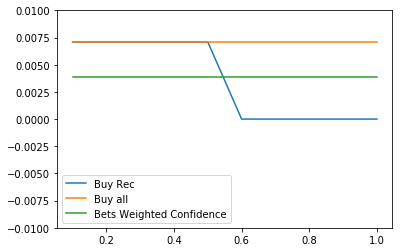

In [38]:
def score(est, X, y, cutoff):
    y_pred = est.predict(X)
    y_pred_proba = est.model.predict_proba(X)
    # Invest if over cutoff% confident 
    y_pred_bool = bool_arr(y_pred, cutoff)
    # Score correct if you make postive returns
    y_true_bool = bool_arr(y, 0)
    
    total = np.dot(y_pred_bool.reshape(X.shape[0],), y)
    confidence_weighted = np.dot(y_pred_proba.reshape(X.shape[0],), y)
    buy_all = np.dot(np.ones(X.shape[0]), y)
    
    av = total/len(X)
    buy_all_av = buy_all/len(X)
    confidence_weighted_av = confidence_weighted/len(X)
    return [av, buy_all_av, confidence_weighted_av]


ys_attained = []
ys_potential = []
ys_confidence_weighted = []
xs = []
for i in np.linspace(0.1, 1, num=10):
    sc = score(deep_estimator, X_test, y_test_continuous,i)
    ys_attained.append(sc[0])
    ys_potential.append(sc[1])
    ys_confidence_weighted.append(sc[2])
    xs.append(i)
    
buy_rec = plt.plot(xs, ys_attained, label='Buy Rec')
buy_all = plt.plot(xs, ys_potential, label='Buy all')
buy_wc = plt.plot(xs, ys_confidence_weighted, label='Bets Weighted Confidence')

ax = plt.gca()

handles, labels = ax.get_legend_handles_labels()
ax.legend()

plt.ylim(-0.01, 0.01)

# set the ylim to ymin, ymax

In [33]:
ys_confidence_weighted = []
ys_potential = []
xs = []

for i in tqdm(np.linspace(0,0.2, num=5)):
    X_train, X_test, y_train_continuous, y_test_continuous = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = bool_arr(y_train_continuous, i)
    y_test = bool_arr(y_test_continuous, i)

    select_fpr = SelectFpr(alpha=0.2)

    X_train = select_fpr.fit_transform(X_train, y_train)
    X_test = select_fpr.transform(X_test)

    deep_estimator = DeepEstimator()
    deep_estimator.fit(X_train, y_train, X_test, y_test)
    
    round_score = score(deep_estimator, X_test, y_test_continuous,0)
    
    buy_all_score = round_score[1]
    bwc_score = round_score[2]
    
    xs.append(i)
    ys_potential.append(buy_all_score)
    ys_confidence_weighted.append(bwc_score)




  0%|          | 0/5 [00:00<?, ?it/s]

Train on 395 samples, validate on 99 samples
Epoch 1/10
395/395 [==============================] - 1s 3ms/step - loss: 782.9136 - acc: 0.4886 - val_loss: 385.5391 - val_acc: 0.5859
Epoch 2/10
395/395 [==============================] - 1s 2ms/step - loss: 184.9604 - acc: 0.4835 - val_loss: 74.3654 - val_acc: 0.5455
Epoch 3/10
395/395 [==============================] - 1s 2ms/step - loss: 62.9197 - acc: 0.5215 - val_loss: 55.8841 - val_acc: 0.4444
Epoch 4/10
395/395 [==============================] - 1s 2ms/step - loss: 51.8920 - acc: 0.5544 - val_loss: 48.8269 - val_acc: 0.5051
Epoch 5/10
395/395 [==============================] - 1s 2ms/step - loss: 43.0366 - acc: 0.5747 - val_loss: 39.6641 - val_acc: 0.5758
Epoch 6/10
395/395 [==============================] - 1s 2ms/step - loss: 36.6025 - acc: 0.5089 - val_loss: 32.4293 - val_acc: 0.4444
Epoch 7/10
395/395 [==============================] - 1s 2ms/step - loss: 29.2403 - acc: 0.5620 - val_loss: 28.7175 - val_acc: 0.4949
Epoch 8/10
395


 20%|██        | 1/5 [00:07<00:31,  7.80s/it]

Train on 395 samples, validate on 99 samples
Epoch 1/10
395/395 [==============================] - 1s 3ms/step - loss: 838.6319 - acc: 0.5013 - val_loss: 319.5284 - val_acc: 0.4848
Epoch 2/10
395/395 [==============================] - 1s 2ms/step - loss: 136.0465 - acc: 0.6076 - val_loss: 71.4278 - val_acc: 0.8485
Epoch 3/10
395/395 [==============================] - 1s 2ms/step - loss: 61.6412 - acc: 0.6304 - val_loss: 53.3218 - val_acc: 0.4040
Epoch 4/10
395/395 [==============================] - 1s 2ms/step - loss: 50.5065 - acc: 0.6557 - val_loss: 44.9282 - val_acc: 0.4444
Epoch 5/10
395/395 [==============================] - 1s 2ms/step - loss: 42.3939 - acc: 0.6785 - val_loss: 38.5857 - val_acc: 0.7778
Epoch 6/10
395/395 [==============================] - 1s 2ms/step - loss: 35.3930 - acc: 0.7342 - val_loss: 30.5746 - val_acc: 0.7778
Epoch 7/10
395/395 [==============================] - 1s 2ms/step - loss: 28.9677 - acc: 0.7696 - val_loss: 25.3562 - val_acc: 0.8081
Epoch 8/10
395


 40%|████      | 2/5 [00:15<00:23,  7.99s/it]

Train on 395 samples, validate on 99 samples
Epoch 1/10
395/395 [==============================] - 1s 3ms/step - loss: 814.4856 - acc: 0.5342 - val_loss: 336.3111 - val_acc: 0.8788
Epoch 2/10
395/395 [==============================] - 1s 2ms/step - loss: 141.8063 - acc: 0.5949 - val_loss: 66.6091 - val_acc: 0.4141
Epoch 3/10
395/395 [==============================] - 1s 2ms/step - loss: 59.3873 - acc: 0.6582 - val_loss: 54.7897 - val_acc: 0.6465
Epoch 4/10
395/395 [==============================] - 1s 2ms/step - loss: 49.9166 - acc: 0.7089 - val_loss: 45.4332 - val_acc: 0.6364
Epoch 5/10
395/395 [==============================] - 1s 2ms/step - loss: 41.3727 - acc: 0.7823 - val_loss: 37.9590 - val_acc: 0.9495
Epoch 6/10
395/395 [==============================] - 1s 2ms/step - loss: 35.3992 - acc: 0.8506 - val_loss: 34.5799 - val_acc: 0.4343
Epoch 7/10
395/395 [==============================] - 1s 2ms/step - loss: 28.8786 - acc: 0.8734 - val_loss: 25.7028 - val_acc: 0.9495
Epoch 8/10
395


 60%|██████    | 3/5 [00:24<00:16,  8.04s/it]

Train on 395 samples, validate on 99 samples
Epoch 1/10
395/395 [==============================] - 1s 3ms/step - loss: 728.5609 - acc: 0.5316 - val_loss: 407.4310 - val_acc: 0.5657
Epoch 2/10
395/395 [==============================] - 1s 2ms/step - loss: 215.1073 - acc: 0.6152 - val_loss: 85.3864 - val_acc: 0.7879
Epoch 3/10
395/395 [==============================] - 1s 2ms/step - loss: 61.8023 - acc: 0.6759 - val_loss: 56.3565 - val_acc: 0.2525
Epoch 4/10
395/395 [==============================] - 1s 2ms/step - loss: 49.3674 - acc: 0.7443 - val_loss: 44.8255 - val_acc: 0.9697
Epoch 5/10
395/395 [==============================] - 1s 2ms/step - loss: 41.6270 - acc: 0.8304 - val_loss: 38.4864 - val_acc: 0.8384
Epoch 6/10
395/395 [==============================] - 1s 2ms/step - loss: 34.4543 - acc: 0.8734 - val_loss: 32.3487 - val_acc: 0.6768
Epoch 7/10
395/395 [==============================] - 1s 2ms/step - loss: 28.3719 - acc: 0.8937 - val_loss: 25.3998 - val_acc: 0.9596
Epoch 8/10
395


 80%|████████  | 4/5 [00:32<00:08,  8.03s/it]

Train on 395 samples, validate on 99 samples
Epoch 1/10
395/395 [==============================] - 1s 3ms/step - loss: 696.7543 - acc: 0.5342 - val_loss: 411.0017 - val_acc: 0.4949
Epoch 2/10
395/395 [==============================] - 1s 2ms/step - loss: 230.0261 - acc: 0.5975 - val_loss: 98.9191 - val_acc: 0.8283
Epoch 3/10
395/395 [==============================] - 1s 2ms/step - loss: 61.5024 - acc: 0.6962 - val_loss: 50.3639 - val_acc: 0.8182
Epoch 4/10
395/395 [==============================] - 1s 2ms/step - loss: 45.5703 - acc: 0.8051 - val_loss: 41.4631 - val_acc: 0.9495
Epoch 5/10
395/395 [==============================] - 1s 2ms/step - loss: 37.9643 - acc: 0.8962 - val_loss: 37.8119 - val_acc: 0.6162
Epoch 6/10
395/395 [==============================] - 1s 2ms/step - loss: 31.1674 - acc: 0.9595 - val_loss: 28.1202 - val_acc: 0.9798
Epoch 7/10
395/395 [==============================] - 1s 2ms/step - loss: 25.2545 - acc: 0.9722 - val_loss: 22.6497 - val_acc: 0.9798
Epoch 8/10
395


100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


# Plot earnings on buying weighted by confidence vs buying all stocks as the prediction threshold increases in training

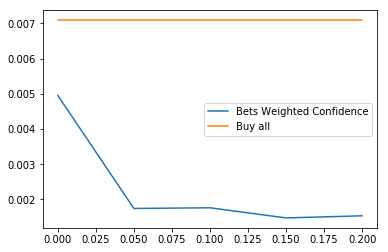

In [34]:
plt.plot(xs, ys_confidence_weighted, label='Bets Weighted Confidence')
buy_all = plt.plot(xs, ys_potential, label='Buy all')

ax = plt.gca()

handles, labels = ax.get_legend_handles_labels()
ax.legend()

In [35]:
y_test_continuous

array([ 5.06329114e-02, -8.33333333e-02,  2.77752315e-02, -5.07614213e-03,
        3.63813020e-02, -5.13392857e-02,  4.96592404e-02,  3.64958496e-02,
        6.07476636e-02,  2.98762271e-03, -3.37804878e-02, -8.06538337e-03,
       -3.45423143e-04,  5.00000000e-02,  1.20481928e-02,  9.83606557e-03,
        1.39475909e-02,  3.27552987e-02,  1.27659574e-02,  1.65539753e-02,
       -4.98960499e-02,  3.86431945e-03,  3.63108206e-03,  1.57728707e-02,
        8.87110802e-03,  6.61150152e-03,  2.71158587e-02, -4.44444444e-02,
       -1.57728707e-02, -3.55439965e-02, -2.62928620e-02,  4.93421053e-03,
        2.36951983e-01,  1.26874279e-02,  2.94627383e-02, -8.69565217e-03,
        9.99826620e-03,  2.28859238e-02,  3.09697933e-02, -1.86831594e-02,
        1.75438596e-02, -3.11662671e-02, -2.27968697e-02,  1.78117048e-02,
       -5.29801325e-02,  9.94087454e-03, -2.50000000e-02, -1.44000000e-01,
        6.03681580e-02,  3.90015601e-02,  2.59342214e-02,  4.15754923e-02,
       -6.39417240e-03,  